In [ ]:
import torch
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import json
import urllib.request
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO


# Load the pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)
model.eval()

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = YOLO("..\models\YOLO_v11\yolo_v11.pt").to(device)

# Download ImageNet class labels
url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
with urllib.request.urlopen(url) as response:
    labels = json.loads(response.read().decode())



# Define transformation for input images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load an example image
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)

# Overlay patch onto image without modifying the original image
def apply_patch_direct(image, patch, location):
    patched_image = image.clone()
    h, w = patch.shape[1:3]
    patched_image[:, :, location[0]:location[0]+h, location[1]:location[1]+w] = patch
    return patched_image

# Visualize the patched image
def visualize_image(image_tensor):
    image_np = image_tensor.squeeze().permute(1, 2, 0).detach().cpu().numpy()
    plt.imshow(np.clip(image_np, 0, 1))
    plt.axis('off')
    plt.show()

# Adversarial patch training loop
def train_patch(image_path, target_class, patch_size=(50, 50), num_steps=500, lr=0.05):
    image = load_image(image_path)
    
    # Initialize random patch with the required size
    patch = torch.rand((3, *patch_size), requires_grad=True)
    optimizer = optim.Adam([patch], lr=lr)

    for step in range(num_steps):
        optimizer.zero_grad()
        
        # Apply patch directly without altering the base image
        patched_image = apply_patch_direct(image, patch, (0, 0))  # Place at the top-left corner
        
        # Forward pass through the model
        output = model(patched_image)
        
        # Calculate loss to maximize the target class probability
        print(output)
        loss = -output[0][target_class]
        loss.backward()
        
        # Update the patch
        optimizer.step()
        
        # Print training progress every 50 steps
        if step % 50 == 0:
            _, predicted_idx = torch.max(output, 1)
            predicted_label = labels[predicted_idx.item()]
            print(f"Step {step}, Loss: {loss.item()}, Predicted label: {predicted_label}")

    return patch

# Define the target class and train the patch on an example image
target_class = 10  # Replace with your desired target class index
image_path = "german_shepard_dog.jpeg"  # Replace with the path to your image 235
trained_patch = train_patch(image_path, target_class, patch_size=(50, 50), num_steps=500, lr=0.05)

# Save the trained adversarial patch
torch.save(trained_patch, "adversarial_patch_direct.pt")

# Load image and apply the adversarial patch for evaluation
image = load_image(image_path)

patched_image = apply_patch_direct(image, trained_patch, (0, 0))  # Place the patch in the same position used during training

# Visualize the patched image
visualize_image(patched_image)

# Classify the patched image
output = model(patched_image)
_, predicted_idx = torch.max(output, 1)
predicted_label = labels[predicted_idx.item()]

print(f"Predicted label after placing patch: {predicted_label}")


c:\Users\somic\Work\Coursework\562\nocap\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\somic\Work\Coursework\562\nocap\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


tensor([[-2.1933e+00, -1.8923e+00, -2.5206e+00,  1.3230e+00, -2.5877e+00, -1.7134e-02, -3.5738e+00,  2.6794e+00,  1.6885e+00,  2.2219e-01, -1.4260e+00, -3.3586e+00, -1.9102e+00, -3.1465e+00, -3.0028e+00, -1.0413e+00, -2.5851e-01, -7.7234e-01, -1.5368e+00, -2.3883e+00, -1.9673e+00,  6.5260e-01, -2.7286e+00,  2.2856e-01,
         -1.6053e+00,  4.8165e-02, -6.0863e-01, -1.7616e+00, -2.0484e+00,  1.0261e+00, -2.8852e-01, -1.9886e+00, -4.6750e-01,  1.5036e+00,  8.0143e-01, -7.7628e-01, -1.0969e+00, -1.9320e+00,  2.4347e-01, -1.9087e+00, -1.0368e+00, -1.3949e+00, -5.9494e-01,  1.0754e+00, -7.7320e-01,  1.3522e-01, -1.6518e+00,  1.6530e+00,
         -1.8721e+00,  7.6006e-01, -5.9865e-02,  4.1751e-01, -4.5724e-01, -2.9276e+00,  4.6023e-01, -2.1026e+00, -4.8792e+00, -2.2418e+00, -1.1206e+00, -3.9166e-01,  2.4160e-01, -2.0842e+00,  3.1673e-02,  1.3408e+00, -9.8472e-01, -1.3818e+00,  1.6336e+00, -1.0271e+00, -7.0018e-01, -1.2646e+00, -2.0203e+00,  1.8972e+00,
         -3.1483e+00, -8.2835e-01, -1

IndexError: list index out of range

In [8]:
#!pip install -U ultralytics

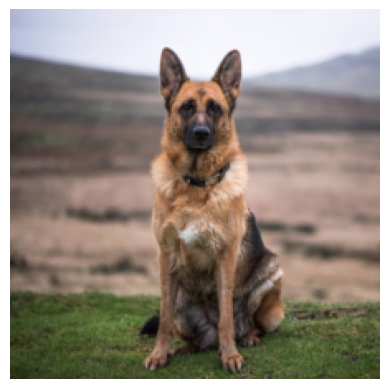

In [2]:
visualize_image(image)

In [5]:
# YOLO V11

# Adversarial patch training loop for YOLO model
def train_patch(image_path, target_class, patch_size=(50, 50), num_steps=500, lr=0.05):
    # Load the base image
    image = load_image(image_path).to(device)
    
    # Initialize random patch with the required size and set requires_grad=True to enable optimization
    patch = torch.rand((3, *patch_size), requires_grad=True, device=device)
    optimizer = optim.Adam([patch], lr=lr)


    for step in range(num_steps):
        optimizer.zero_grad()
        
        # Apply patch to the image at a specified location (top-left corner here)
        patched_image = apply_patch_direct(image, patch, (0, 0))
        
        # Forward pass through the YOLO model
        output = model(patched_image)

        # Extract detection results for the target class
        # In YOLO, output typically includes bounding box coordinates, confidence, and class scores
        # We filter for scores related to the target class
        target_confidences = []
        for detection in output[0].boxes:
            class_id = int(detection.cls.item())
            if class_id == target_class:
                target_confidences.append(detection.conf)

        # If there are no detections for the target class, set loss to zero
        if target_confidences:
            # Calculate loss to maximize the confidence of the target class
            loss = -torch.stack(target_confidences).mean()  # Negative to maximize the confidence score
        else:
            loss = torch.tensor(0.0, requires_grad=True, device=device)  # No detections, no loss contribution

        # Backward pass to update the patch
        loss.backward()
        optimizer.step()
        
        # Print training progress every 50 steps
        if step % 50 == 0:
            print(f"Step {step}, Loss: {loss.item()}, Target Class Detected: {len(target_confidences) > 0}")

    return patch

# Example usage: Define the target class and train the patch on an example image
target_class = 10  # Replace with your desired target class index
image_path = "german_shepard_dog.jpeg"  # Replace with the path to your image
trained_patch = train_patch(image_path, target_class, patch_size=(50, 50), num_steps=500, lr=0.05)
